starting repetition  1 / 2
starting repetition  2 / 2


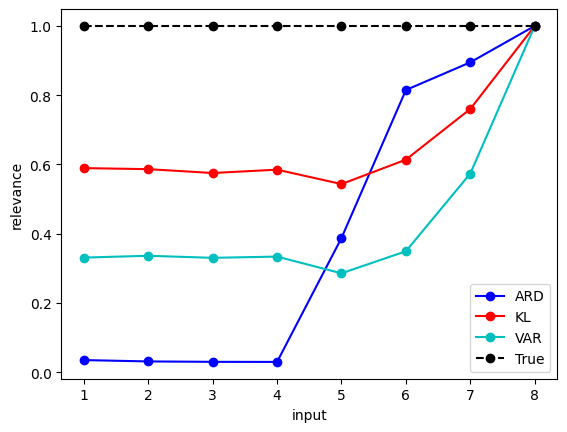

In [3]:
import GPy
import numpy as np
from matplotlib import pyplot as plt

import sys
sys.path.append('code')
import function as varsel

np.random.seed(1)



# number of repetitions to average over
repeats = 2
# number of covariates
m = 8
# number of data points
n = 300
# Delta for KL method
delta = 0.0001
# number of quadrature points for VAR method
nquadr = 11

# if x are uniformly distributed
# compute the analytical scaling coefficients for the m components
phi = np.pi*np.linspace(0.1,1,m);
Aunif = np.zeros(m)
for i in range(0,m):
    Aunif[i] = np.sqrt( 4/(2 -1/phi[i]*np.sin(2*phi[i])) )

# if x are normally distributed
# compute the scaling coefficients for the m components
nquadr2 = 11
[points,weights] = np.polynomial.hermite.hermgauss(nquadr2)
std = 0.4
Anor = np.zeros(m)
for i in range(0, m):
    coeff = np.sin(phi[i]*np.sqrt(2)*std*points)*np.sin(phi[i]*np.sqrt(2)*std*points)
    var = 1.0/np.sqrt(np.pi)*np.dot(coeff.T,weights)
    Anor[i] = 1/np.sqrt(var)


rel_ARD = np.zeros(m)
rel_KL = np.zeros(m)
rel_VAR = np.zeros(m)
for i in range(0, repeats):
    x = np.random.uniform(-1.,1.,(n,m))
    #x = np.random.normal(0.0,std,(n,m))
    print('starting repetition ', i + 1,'/',repeats)
    phi = np.tile(np.linspace(np.pi/10,np.pi,m),(n,1))
    xphi = np.multiply(x[:,0:m],phi)
    f = np.sin(xphi)
    for j in range(0,m):
        f[:,j] = f[:,j]*Aunif[j]    
        #f[:,j] = f[:,j]*Anor[j]
    
    # y is a sum of the m components plus Gaussian noise
    yval = f.sum(axis=1) + np.random.normal(0,0.3,(n,))
    y = np.asmatrix(yval).T
    
    # RBF kernel plus constant term
    kernel = GPy.kern.RBF(input_dim=m,ARD=True) + GPy.kern.Bias(input_dim=m)
    model = GPy.models.GPRegression(x,y,kernel)
    model.optimize()
    
    # ARD relevance value is the inverse of the length scale
    rel_ARD = rel_ARD + 1/model.sum.rbf.lengthscale
    
    # KL relevance value
    rel_KL = rel_KL + varsel.KLrel(x,model,delta)
    
    # VAR relevance value
    rel_VAR = rel_VAR + varsel.VARrel(x,model,nquadr)
    
 
# normalize the relevance values      
rel_ARD_nor = rel_ARD/np.max(rel_ARD)
rel_KL_nor = rel_KL/np.max(rel_KL)
rel_VAR_nor = rel_VAR/np.max(rel_VAR)

# True relevance, the covariates are equally relevant in the L2 sense
rel_true = np.ones(m)

# plot
covariates = np.arange(1,m+1) 
fig2 = plt.figure()
ax2 = plt.subplot(111)
ax2.plot(covariates,rel_ARD_nor,'-ob',label='ARD')
ax2.plot(covariates,rel_KL_nor,'-or',label='KL')
ax2.plot(covariates,rel_VAR_nor,'-oc',label='VAR')
ax2.plot(covariates,rel_true,'--ok',label='True')
ax2.legend()
ax2.set_ylabel('relevance')
ax2.set_xlabel('input')
plt.show()